Imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import networkx as nx
import heapq
import random
from collections import namedtuple
from matplotlib.ticker import PercentFormatter

# SEIR

First, we implement the SEIR model computing the solution with Runge-Kutta method of scipy.

In [24]:
def SEIR(t, y, phi, rho, TE, TI, N):
    """
    Defines the system of ODEs for the classical SEIR model.

    Parameters:
    - t : float
        Time variable (not used explicitly, required by ODE solvers).
    - y : list or array
    - phi : float
        Average number of daily contacts per individual.
    - rho : float
        Probability of transmission per contact.
    - TE : float
        Average incubation period (time from exposure to becoming infectious).
    - TI : float
        Average infectious period (time from becoming infectious to recovery).
    - N : int or float
        Total population size.

    Returns:
    - List of derivatives [dS/dt, dE/dt, dI/dt, dR/dt].
    """
    S, E, I, R = y
    beta = phi * rho  # Effective contact rate
    sigma = 1 / TE     # Rate of progression from exposed to infectious
    gamma = 1 / TI     # Recovery rate

    dSdt = -beta * I * S / N          # New infections
    dEdt = beta * I * S / N - sigma * E  # Exposed becoming infectious
    dIdt = sigma * E - gamma * I      # Infectious individuals recovering
    dRdt = gamma * I                  # Recovered individuals
    return [dSdt, dEdt, dIdt, dRdt]


def simulate_SEIR(phi, rho, TE, TI, N, y0, t_span, t_eval):
    """
    Solves the SEIR model over time using a numerical ODE solver (Runge-Kutta 4(5)).
    """
    return solve_ivp(
        SEIR,
        t_span,
        y0,
        t_eval=t_eval,
        method='RK45',
        args=(phi, rho, TE, TI, N)
    )


def plot_all_variables_SEIR(params):
    """
    Simulates and plots the SEIR model dynamics over time as percentages of the total population.

    Parameters:
    - params : dict
        Dictionary containing all model parameters:
            - 'phi', 'rho', 'TE', 'TI', 'N', 'y0', 't_span', 't_eval'

    Output:
    - A matplotlib plot showing the evolution of S, E, I, R as percentages of the population.
    """
    sol = simulate_SEIR(
        params['phi'], params['rho'],
        params['TE'], params['TI'],
        params['N'], params['y0'],
        params['t_span'], params['t_eval']
    )

    labels = ['S', 'E', 'I', 'R']
    colors = ['#1CA9A9', '#E63946', '#F4A261', '#171C6F']
    N = params['N']

    plt.figure(figsize=(12, 8))
    for i in range(4):
        plt.plot(sol.t, sol.y[i] / N, label=labels[i], color=colors[i])  # Normalize values to show as % of population

    plt.xlabel('Time (days)')
    plt.ylabel('Percentage of Population')
    plt.ylim(0, 1.0)
    plt.title('SEIR Dynamics')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))  # Format y-axis as percentages
    plt.legend()
    plt.grid(True)
    plt.show()


We define the final parameters chosen for the basic SEIR model, and we plot our results. For the hypeparameter optimization of SEIR, this id done with the same function written later for SEIR with TTI using the probability of detection of 0.

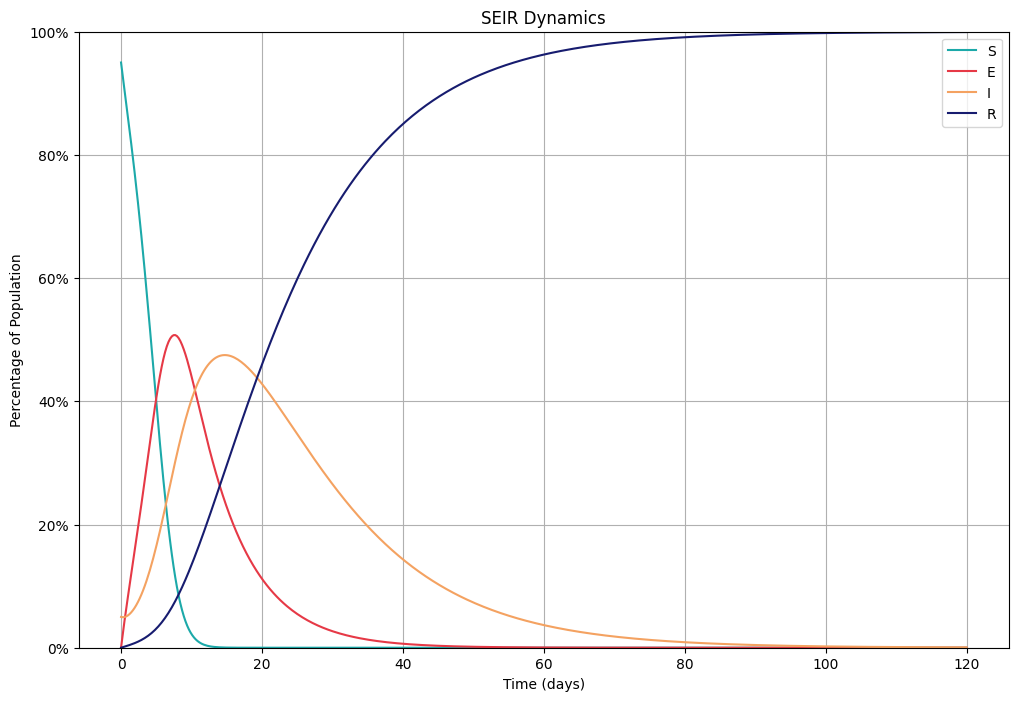

In [25]:
# --- Fixed model parameters ---

N = 1000
E0 = 0
I0 = 50
R0 = 0
S0 = N - E0 - I0 - R0
y0 = [S0, E0, I0, R0]

params = {
    'phi': 20,
    'rho': 0.1,
    'TE': 7,          # Latent period
    'TI': 14,         # Infectious period
    'N': N,
    'y0': y0,
    't_span': (0, 120),
    't_eval': np.linspace(0, 120, 500)
}
plot_all_variables_SEIR(params)

# SEIR with TTI

Definition of the model

In [26]:
def SEIR_TTI(t, y, phi, rho, mu_ID_E, TE, TID, TIU, N):
    S, E, ID, IU, R = y
    dSdt = -phi * rho * IU * S / N
    dEdt = phi * rho * IU * S / N - (1 / TE) * E
    dIDdt = (mu_ID_E / TE) * E - (1 / TID) * ID
    dIUdt = (1 - mu_ID_E) / TE * E - (1 / TIU) * IU
    dRdt = (1 / TID) * ID + (1 / TIU) * IU
    return [dSdt, dEdt, dIDdt, dIUdt, dRdt]

In [27]:
# Function to simulate and solve the model
def simulate_SEIR_TTI(phi, rho, mu_ID_E, TE, TID, TIU, N, y0, t_span, t_eval):
    sol = solve_ivp(
        SEIR_TTI,
        t_span,
        y0,
        t_eval=t_eval,
        method='RK45',
        args=(phi, rho, mu_ID_E, TE, TID, TIU, N)
    )
    return sol

Again, here we define the fixed parameters. When we will study how the model changes with different values of one parameters, we will leave fixed the other ones with the value defined here.

In [41]:
# --- Fixed model parameters ---

N = 1000
E0 = 50
ID0 = 0
IU0 = 0
R0 = 0
S0 = N - E0 - ID0 - IU0 - R0
y0 = [S0, E0, ID0, IU0, R0]

fixed_params = {
    'phi': 20,
    'rho': 0.1,
    'mu_ID_E': 0.6,
    'TE': 7,
    'TID': 14,
    'TIU': 14,
    'N': N,
    'y0': y0,
    't_span': (0, 120),
    't_eval': np.linspace(0, 120, 1000)
}


Auxiliary function that permits study the variation of one hyperparameter in the model:

In [42]:
def vary_hyperparameter(hyperparam_name, values, fixed_params, var1='ID', var2='IU', show_var2=False):
    """
    Plot the effect of varying a hyperparameter on one or two state variables.

    Parameters:
    - hyperparam_name: str, name of the hyperparameter to vary (e.g., 'phi')
    - values: list or array of values to try
    - fixed_params: dict with the rest of the model parameters
    - var1: str, first variable to plot ('S', 'E', 'ID', 'IU', 'R') - always shown (solid line)
    - var2: str, second variable to plot ('S', 'E', 'ID', 'IU', 'R') - shown if show_var2 is True (dashed line)
    - show_var2: bool, whether to include the second variable (default True)
    """

    variable_index = {'S': 0, 'E': 1, 'ID': 2, 'IU': 3, 'R': 4}
    if var1 not in variable_index or (show_var2 and var2 not in variable_index):
        raise ValueError("Invalid variable name(s). Must be one of 'S', 'E', 'ID', 'IU', 'R'.")

    idx1 = variable_index[var1]
    idx2 = variable_index[var2] if show_var2 else None

    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap('tab10')

    for i, val in enumerate(values):
        params = fixed_params.copy()
        params[hyperparam_name] = val

        sol = simulate_SEIR_TTI(
            params['phi'], params['rho'], params['mu_ID_E'],
            params['TE'], params['TID'], params['TIU'],
            params['N'], params['y0'],
            params['t_span'], params['t_eval']
        )

        color = cmap(i % 10)

        # Plot var1 (solid)
        plt.plot(sol.t, sol.y[idx1] / params['N'], label=f"{val:.3f} ({var1})", color=color, linestyle='-')

        # Plot var2 (dashed) if enabled
        if show_var2:
            plt.plot(sol.t, sol.y[idx2] / params['N'], label=f"{val:.3f} ({var2})", color=color, linestyle='--')

    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.ylim(0, 1.0)
    plt.title(f'Effect of varying {hyperparam_name} on {var1}' + (f' and {var2}' if show_var2 else ''))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))  # Format y-axis as %
    plt.legend(title=hyperparam_name)
    plt.grid(True)
    plt.show()

Experiments of the variation of some hyperparameters:

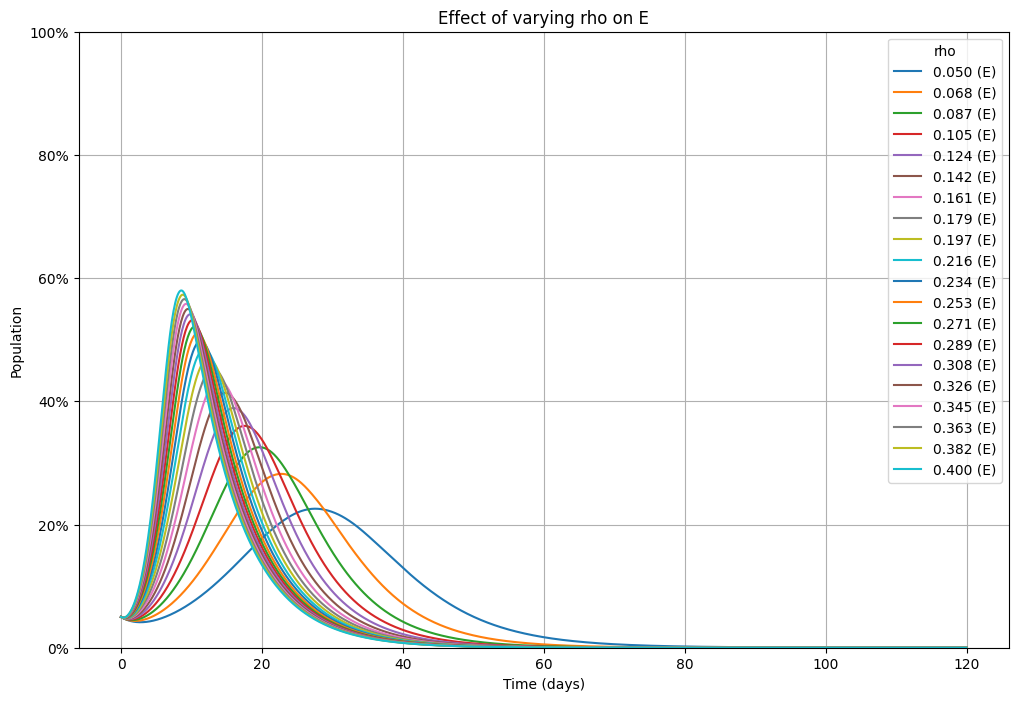

In [43]:
# Vary rho between 0.2 and 1.0
rho_values = np.linspace(0.05, 0.4, 20)
vary_hyperparameter('rho', rho_values, fixed_params, var1 = 'E')

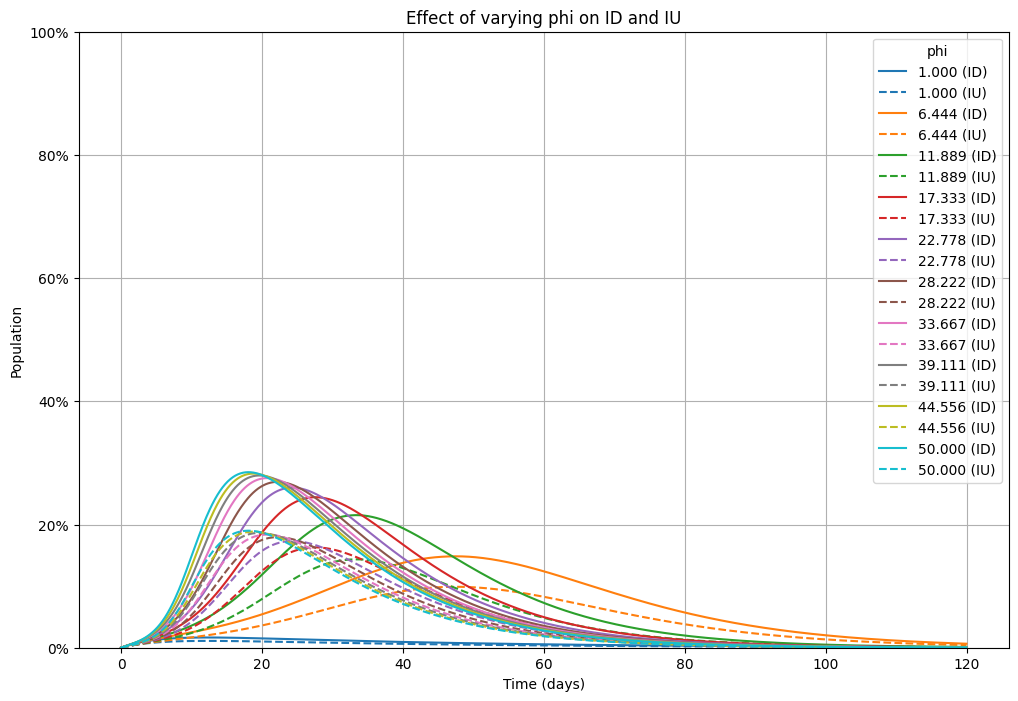

In [44]:
# Vary phi between 1 and 50
phi_values = np.linspace(1, 50, 10)
vary_hyperparameter('phi', phi_values, fixed_params, show_var2=True)

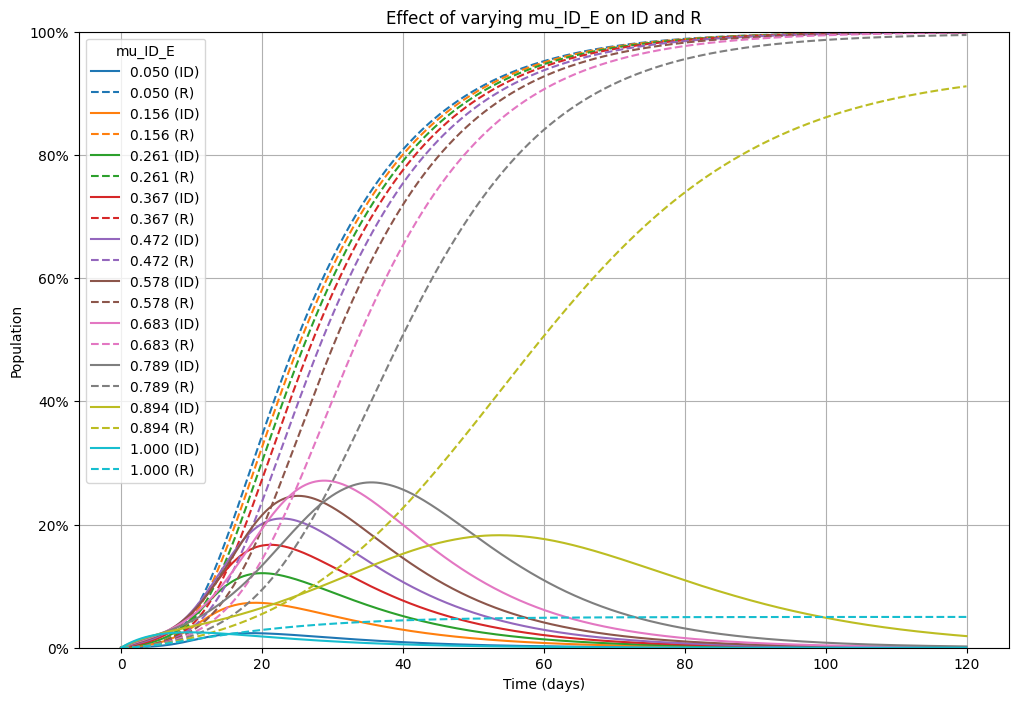

In [54]:
# Vary mu between 0.05 and 1.0
mu_values = np.linspace(0.05, 1.0, 10)
vary_hyperparameter('mu_ID_E', mu_values, fixed_params, var2 = 'R' ,show_var2=True)

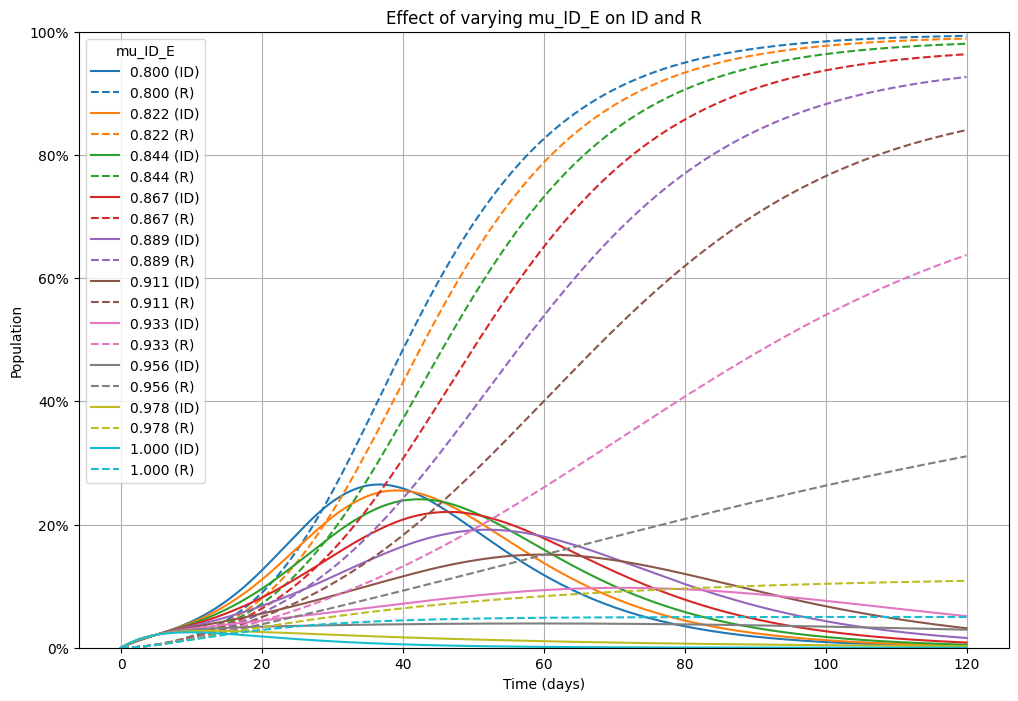

In [33]:
# Vary mu between 0.05 and 1.0
mu_values = np.linspace(0.8, 1.0, 10)
vary_hyperparameter('mu_ID_E', mu_values, fixed_params, var2 = 'R' ,show_var2=True)

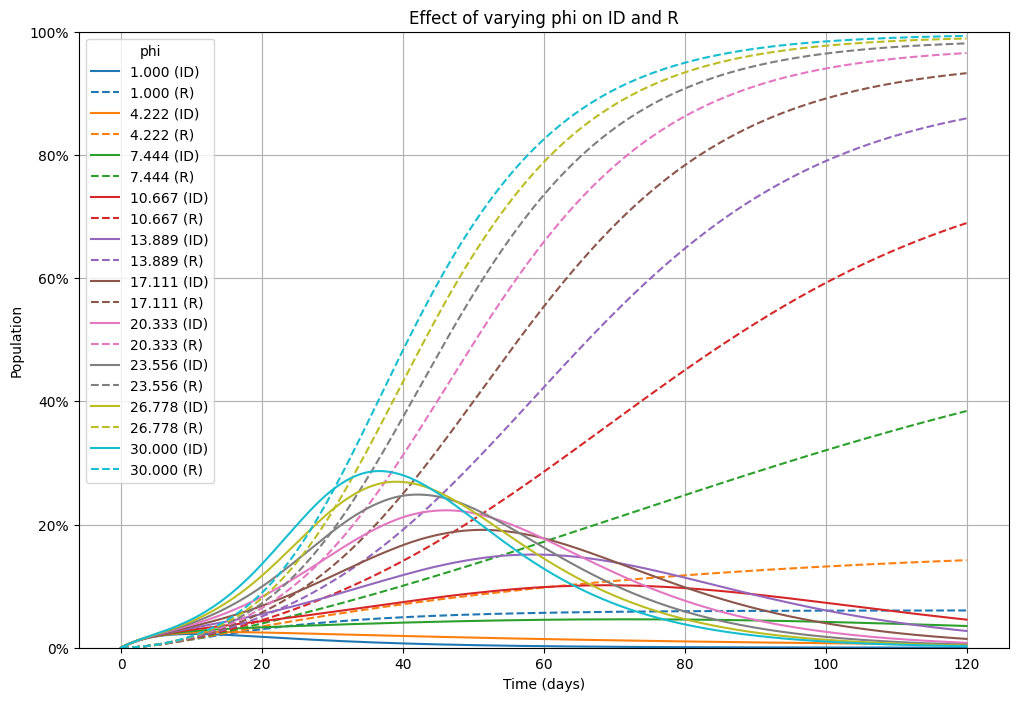

In [47]:
new_params = {
    'phi': 20,
    'rho': 0.1,
    'mu_ID_E': 0.867,
    'TE': 7,
    'TID': 14,
    'TIU': 14,
    'N': N,
    'y0': y0,
    't_span': (0, 120),
    't_eval': np.linspace(0, 120, 1000)
}

# Vary phi between 1 and 50
phi_values = np.linspace(1, 30, 10)
vary_hyperparameter('phi', phi_values, new_params, var2 = 'R' ,show_var2=True)

Auxiliary function to plot the final model of SEIR with TTI

In [34]:
def plot_all_variables_TTI(params=fixed_params):
    """
    Simulate and plot all state variables (S, E, ID, IU, R) over time,
    along with total infected (ID + IU), using given parameters or defaults.
    """

    # Solve the system
    sol = simulate_SEIR_TTI(
        params['phi'], params['rho'], params['mu_ID_E'],
        params['TE'], params['TID'], params['TIU'],
        params['N'], params['y0'],
        params['t_span'], params['t_eval']
    )

    labels = ['S', 'E', 'ID', 'IU', 'R']
    colors = ['#1CA9A9', '#E63946', '#F4A261', 'orange', '#171C6F']
    plt.figure(figsize=(12, 8))

    for i in range(5):
        plt.plot(sol.t, sol.y[i] / params["N"], label=labels[i], color=colors[i])

    # Add total infected (ID + IU)
    total_infected = sol.y[2] + sol.y[3]
    plt.plot(sol.t, total_infected / params["N"], label='Total Infected (ID + IU)', color='black', linestyle='--')

    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title('SEIR Dynamics with TTI')
    plt.ylim(0, 1.0)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.legend()
    plt.grid(True)
    plt.show()

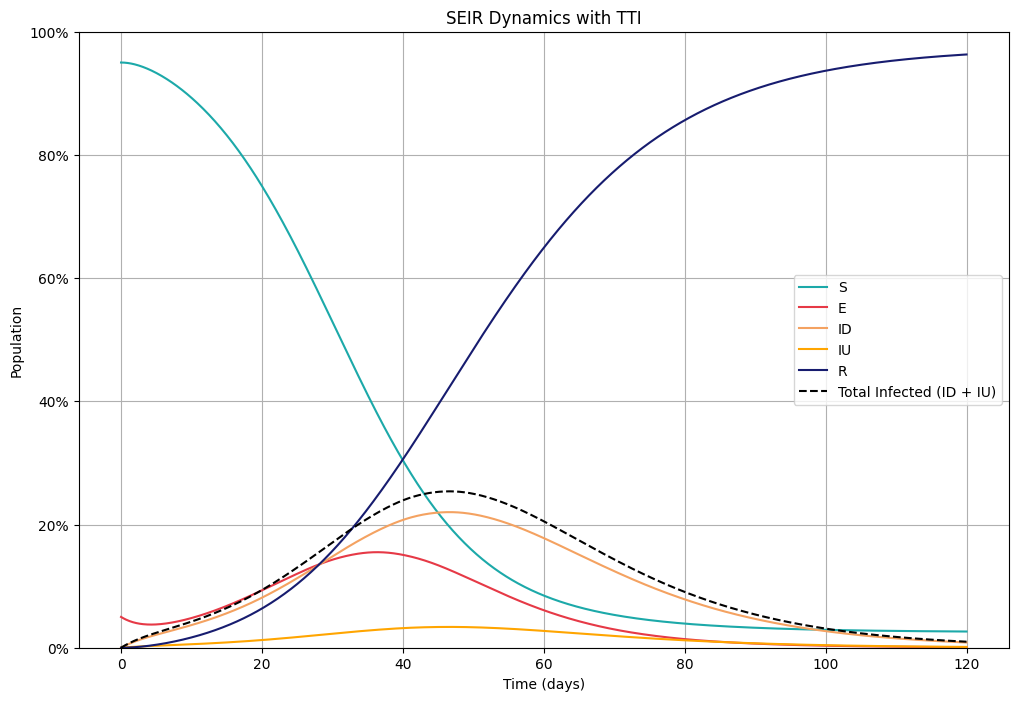

In [35]:
new_params = {
    'phi': 20,
    'rho': 0.1,
    'mu_ID_E': 0.867,
    'TE': 7,
    'TID': 14,
    'TIU': 14,
    'N': N,
    'y0': y0,
    't_span': (0, 120),
    't_eval': np.linspace(0, 120, 1000)
}
plot_all_variables_TTI(new_params)

# Stratified SEIR TTI

Same of before, but now stratified

In [8]:
def stratified_SEIR_TTI(t, y, phi, rho, mu_ID_E, TE, TID, TIU, N_vec):
    n = len(N_vec)
    S = y[0:n]
    E = y[n:2*n]
    ID = y[2*n:3*n]
    IU = y[3*n:4*n]
    R = y[4*n:5*n]

    dSdt = np.zeros(n)
    dEdt = np.zeros(n)
    dIDdt = np.zeros(n)
    dIUdt = np.zeros(n)
    dRdt = np.zeros(n)

    for i in range(n):
        lambda_i = sum(phi[i, j] * IU[j] / N_vec[j] for j in range(n))
        dSdt[i] = -rho[i] * S[i] * lambda_i
        dEdt[i] = rho[i] * S[i] * lambda_i - (1 / TE[i]) * E[i]
        dIDdt[i] = (mu_ID_E[i] / TE[i]) * E[i] - (1 / TID[i]) * ID[i]
        dIUdt[i] = ((1 - mu_ID_E[i]) / TE[i]) * E[i] - (1 / TIU[i]) * IU[i]
        dRdt[i] = (1 / TID[i]) * ID[i] + (1 / TIU[i]) * IU[i]

    return np.concatenate([dSdt, dEdt, dIDdt, dIUdt, dRdt])

In [9]:
def simulate_stratified_SEIR_TTI(phi, rho, mu_ID_E, TE, TID, TIU, N_vec, y0, t_span, t_eval):
    sol = solve_ivp(
        stratified_SEIR_TTI,
        t_span,
        y0,
        t_eval=t_eval,
        method='RK45',
        args=(phi, rho, mu_ID_E, TE, TID, TIU, N_vec)
    )
    return sol

Function to plot the dynamics. In this case we have to pass a new parameter indicating what group we want to see the dynamics.

In [49]:
def plot_group_dynamics_SEIR(sol, group_index, t_eval, N_vec):
    i = group_index

    n = len(sol.y) // 5
    S = np.array(sol.y[0:n]) / N_vec[i]
    E = np.array(sol.y[n:2*n]) / N_vec[i]
    ID = np.array(sol.y[2*n:3*n]) / N_vec[i]
    IU = np.array(sol.y[3*n:4*n]) / N_vec[i]
    R = np.array(sol.y[4*n:5*n]) / N_vec[i]

    plt.figure(figsize=(10, 6))
    plt.plot(t_eval, S[i], label=f"S_{i+1} (Susceptible)")
    plt.plot(t_eval, E[i], label=f"E_{i+1} (Exposed)")
    plt.plot(t_eval, ID[i], label=f"ID_{i+1} (Detected Infectious)")
    plt.plot(t_eval, IU[i], label=f"IU_{i+1} (Undetected Infectious)")
    plt.plot(t_eval, R[i], label=f"R_{i+1} (Recovered)")
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.ylim(0, 1.0)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.title(f"Group {i+1} SEIR-TTI Dynamics")
    plt.legend()
    plt.grid(True)
    plt.show()

As before, we define the fixed hyperparameters.

In [60]:
n = 3
N_vec = np.array([100, 300, 600])
S0 = [100, 300, 550]
E0 = np.array([0, 0, 50])
ID0 = np.zeros(n)
IU0 = np.zeros(n)
R0 = np.zeros(n)
y0 = np.concatenate([S0, E0, ID0, IU0, R0])

t_span = (0, 120)
t_eval = np.linspace(0, 120, 1000)

phi = np.array([
    [2, 3, 4],
    [1, 4, 6],
    [1, 4, 15]
])

rho = np.array([0.1, 0.1, 0.1])
mu_ID_E = np.array([0.8, 0.8, 0.8])
TE = np.array([7, 7, 7])
TID = np.array([14, 14, 14])
TIU = np.array([14, 14, 14])

sol = simulate_stratified_SEIR_TTI(phi, rho, mu_ID_E, TE, TID, TIU, N_vec, y0, t_span, t_eval)

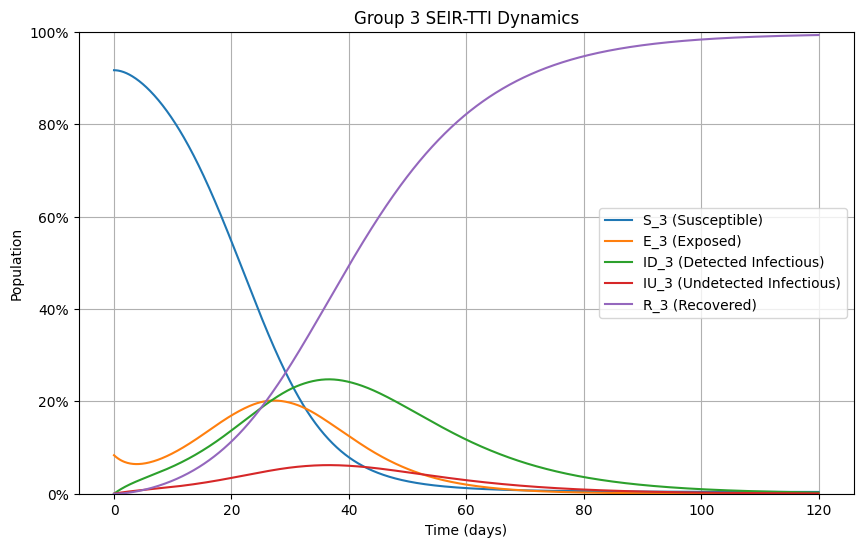

In [66]:
plot_group_dynamics_SEIR(sol, group_index=2, t_eval=t_eval, N_vec=N_vec)  # grupo 2

We define the auxiliary function for the studying of the variation of the hyperparameters. In this case we have to manage matrices and allos the variation of these matruces.

In [31]:
def vary_param_matrix_SEIR_TTI(
    param_name, param_matrices, fixed_params,
    group_index=0, var1='ID', var2='IU', show_var2=False
):
    """
    Plot the effect of varying an entire matrix-valued parameter for a specific group.

    Parameters:
    - param_name: str, name of the parameter to vary ('phi', 'rho', 'mu_ID_E', 'TE', 'TID', 'TIU')
    - param_matrices: list of matrices or vectors to test for the parameter
    - fixed_params: dict, with the remaining parameters needed for the model
    - group_index: int, index of the demographic group to plot
    - var1: str, main variable to plot ('S', 'E', 'ID', 'IU', 'R') - shown as solid line
    - var2: str, optional second variable to plot - shown as dashed line
    - show_var2: bool, whether to include var2 in the plot
    """
    variable_index = {'S': 0, 'E': 1, 'ID': 2, 'IU': 3, 'R': 4}
    if var1 not in variable_index or (show_var2 and var2 not in variable_index):
        raise ValueError("Invalid variable names. Use one of: 'S', 'E', 'ID', 'IU', 'R'")

    idx1 = variable_index[var1]
    idx2 = variable_index[var2] if show_var2 else None

    n = len(fixed_params['N_vec'])
    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap('tab10')

    for i, matrix in enumerate(param_matrices):
        params = fixed_params.copy()
        params[param_name] = matrix

        sol = simulate_stratified_SEIR_TTI(
            params['phi'], params['rho'], params['mu_ID_E'],
            params['TE'], params['TID'], params['TIU'],
            params['N_vec'], params['y0'],
            params['t_span'], params['t_eval']
        )

        offset1 = idx1 * n + group_index
        y1 = sol.y[offset1]
        color = cmap(i % 10)
        plt.plot(sol.t, y1 / params['N_vec'][group_index], label=f"{param_name} {i} ({var1})", linestyle='-', color=color)

        if show_var2:
            offset2 = idx2 * n + group_index
            y2 = sol.y[offset2]
            plt.plot(sol.t, y2 / params['N_vec'][group_index], label=f"{param_name} {i} ({var2})", linestyle='--', color=color)

    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title(f'Effect of varying {param_name} on group {group_index+1}: {var1}' +
              (f' and {var2}' if show_var2 else ''))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.legend(title=param_name)
    plt.grid(True)
    plt.show()

Final experiment with the variation of the $\phi$ matrix.

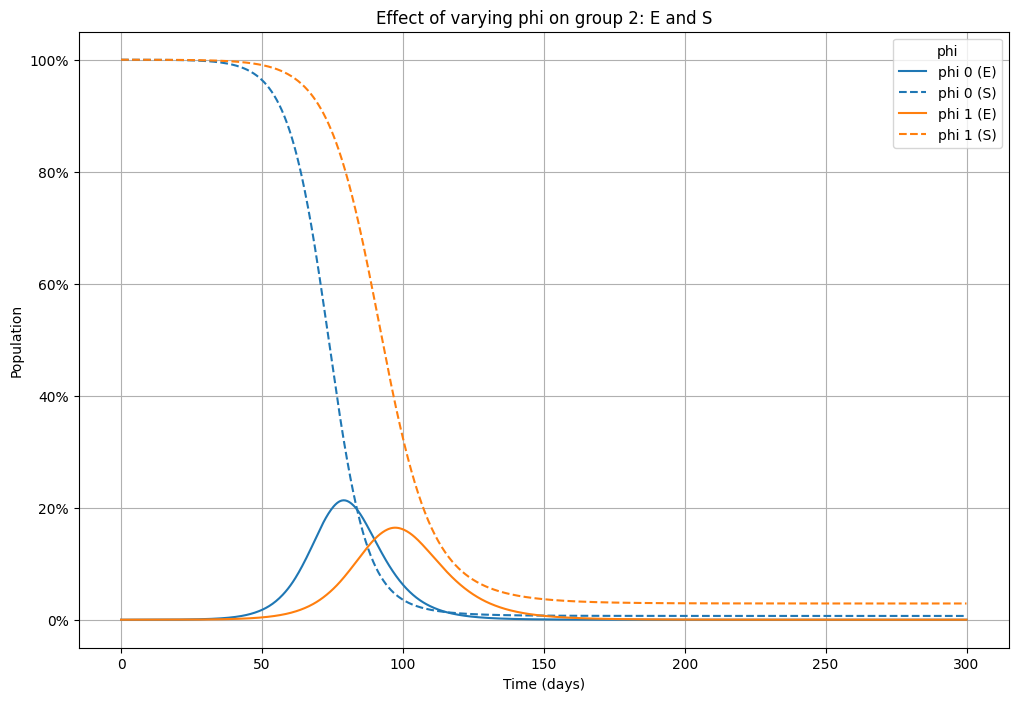

In [33]:
# Number of demographic groups
n = 3

# Population per group
N_vec = np.array([100, 300, 600])
N_total = np.sum(N_vec)

# Initial condition: one infected in group 0
S0 = N_vec.copy()
E0 = np.zeros(n)
ID0 = np.zeros(n)
IU0 = np.zeros(n)
R0 = np.zeros(n)
IU0[0] = 1
S0[0] -= 1

# Combine into one flat y0 vector: [S, E, ID, IU, R]
y0 = np.concatenate([S0, E0, ID0, IU0, R0])

# Time span
t_span = (0, 300)
t_eval = np.linspace(*t_span, 1000)

# Fixed scalar or vector parameters (1D arrays per group)
rho = np.ones(n) * 0.1
mu_ID_E = np.ones(n) * 0.8
TE = np.ones(n) * 7
TID = np.ones(n) * 14
TIU = np.ones(n) * 14

# Define two different contact matrices (phi) for comparison
phi1 = np.array([
    [5, 2, 4],
    [2, 10, 6],
    [4, 6, 15]
])

phi2 = np.array([
    [5, 2, 3],
    [2, 7, 4],
    [3, 4, 13]
])

# Collect fixed params
fixed_params = {
    'rho': rho,
    'mu_ID_E': mu_ID_E,
    'TE': TE,
    'TID': TID,
    'TIU': TIU,
    'phi': phi1,  # will be overwritten inside the function
    'N_vec': N_vec,
    'y0': y0,
    't_span': t_span,
    't_eval': t_eval
}

# Use the vary function
vary_param_matrix_SEIR_TTI(
    param_name='phi',
    param_matrices=[phi1, phi2],
    fixed_params=fixed_params,
    group_index=1,  # Plot for group 0
    var1='E',
    var2='S',
    show_var2=True
)


# Event- based simulation

Experiment with the implementation of our own event-based algorithm for the SEIR model.

## SEIR

Possible states of the queue.

In [34]:
SUSCEPTIBLE = 'S'
EXPOSED = 'E'
INFECTIOUS = 'I'
RECOVERED = 'R'

EXPOSE_EVENT = 'expose'
BECOME_INFECTIOUS_EVENT = 'become_infectious'
RECOVER_EVENT = 'recover'

In [61]:
def seir_event_based(G, initially_infected, TE, TI, rho, t_max):
    """
    Simulates the SEIR model using an event-based approach on a given contact network.

    Parameters:
    - G : networkx.Graph
        Graph representing the contact network between individuals.
    - initially_infected : list
        List of nodes initially exposed to the disease.
    - TE : int
        Incubation period (duration in the Exposed state before becoming Infectious).
    - TI : int
        Infectious period (duration in the Infectious state before Recovery).
    - rho : float
        Probability of transmission per contact per time step.
    - t_max : int
        Maximum simulation time.

    Returns:
    - time_series : dict
        Time series of population counts for each compartment: Susceptible, Exposed, Infectious, Recovered.
    """
    # Initialize all nodes as susceptible
    states = {node: SUSCEPTIBLE for node in G.nodes()}

    # Priority queue for event scheduling
    event_queue = []

    # Time series data storage
    time_series = {'time': [], 'S': [], 'E': [], 'I': [], 'R': []}

    # Dictionary to track remaining infectious time for each infectious node
    infectious_timers = {}

    # Initialization: set initially infected as INFECTIOUS and schedule their recovery
    for node in initially_infected:
        states[node] = INFECTIOUS
        infectious_timers[node] = TI
        heapq.heappush(event_queue, Event(0 + TI, node, RECOVER_EVENT))

    current_time = 1

    while current_time <= t_max:
        # Process all events scheduled for the current time
        while event_queue and event_queue[0].time <= current_time:
            event = heapq.heappop(event_queue)
            node = event.node

            if event.event_type == EXPOSE_EVENT and states[node] == EXPOSED:
                # Schedule transition to infectious state
                heapq.heappush(event_queue, Event(current_time + TE, node, BECOME_INFECTIOUS_EVENT))

            elif event.event_type == BECOME_INFECTIOUS_EVENT and states[node] == EXPOSED:
                # Node becomes infectious
                states[node] = INFECTIOUS
                infectious_timers[node] = TI
                heapq.heappush(event_queue, Event(current_time + TI, node, RECOVER_EVENT))

            elif event.event_type == RECOVER_EVENT and states[node] == INFECTIOUS:
                # Node recovers
                states[node] = RECOVERED
                infectious_timers.pop(node, None)

        # Infectious nodes attempt to infect their susceptible neighbors
        for node in list(infectious_timers):
            if infectious_timers[node] > 0 and states[node] == INFECTIOUS:
                for neighbor in G.neighbors(node):
                    if states[neighbor] == SUSCEPTIBLE:
                        if random.random() < rho:
                            states[neighbor] = EXPOSED
                            heapq.heappush(event_queue, Event(current_time, neighbor, EXPOSE_EVENT))
                infectious_timers[node] -= 1  # Decrease remaining infectious time

        # Record the current state counts
        counts = {SUSCEPTIBLE: 0, EXPOSED: 0, INFECTIOUS: 0, RECOVERED: 0}
        for state in states.values():
            counts[state] += 1

        time_series['time'].append(current_time)
        time_series['S'].append(counts[SUSCEPTIBLE])
        time_series['E'].append(counts[EXPOSED])
        time_series['I'].append(counts[INFECTIOUS])
        time_series['R'].append(counts[RECOVERED])

        # Advance simulation time
        current_time += 1

    return time_series

Final hyperparameters chosen in the experimentation of the mathematical model.

In [62]:
N = 1000
phi = 20
rho = 0.1
TE = 7
TI = 14
t_max = 120

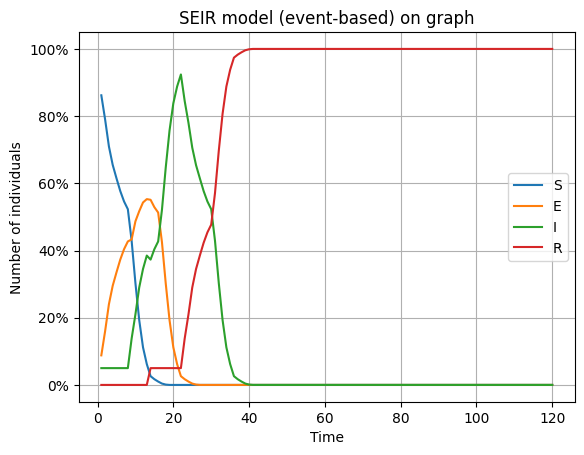

In [63]:
G = nx.random_regular_graph(d=phi, n=N)
timeline = seir_event_based(G, initially_infected=list(range(1, 51)), TE=TE, TI=TI, rho=rho, t_max=t_max)

times = timeline['time']
S_vals = np.array(timeline['S']) / N
E_vals = np.array(timeline['E']) / N
I_vals = np.array(timeline['I']) / N
R_vals = np.array(timeline['R']) / N

plt.plot(times, S_vals, label='S')
plt.plot(times, E_vals, label='E')
plt.plot(times, I_vals, label='I')
plt.plot(times, R_vals, label='R')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.title('SEIR model (event-based) on graph')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend()
plt.grid(True)
plt.show()


# Other experiments (failed)

The experimentation involved implementing the event-based algorithm for both the SEIR-TTI model and the stratified version. However, due to the group's final decision to adopt the Gillespie algorithm using the EoN library, further experimentation on these models was discontinued. Nevertheless, this work is included here in case it proves useful.

## SEIR with TTI

In [65]:
# Define constants for clarity
SUSCEPTIBLE = 'S'
EXPOSED = 'E'
INFECTED_DETECTED = 'ID'
INFECTED_UNDETECTED = 'IU'
RECOVERED = 'R'

EXPOSE_EVENT = 1
BECOME_INFECTIOUS_EVENT = 2
INFECT_DETECTED_EVENT = 3
INFECT_UNDETECTED_EVENT = 4
RECOVER_EVENT = 5

Event = namedtuple('Event', ['time', 'node', 'event_type'])

In [66]:
def run_seir_tti_event_based(G, initial_infected, phi, rho, mu_ID_E, TE, TID, TIU, t_max=300):
    states = {node: SUSCEPTIBLE for node in G.nodes()}
    event_queue = []
    time_series = {'time': [], 'S': [], 'E': [], 'ID': [], 'IU': [], 'R': []}
    infected_timers = {}

    for node in initial_infected:
        states[node] = EXPOSED
        heapq.heappush(event_queue, Event(0, node, EXPOSE_EVENT))

    current_time = 0

    while current_time <= t_max:
        # Process any event scheduled for current time
        while event_queue and event_queue[0].time <= current_time:
            event = heapq.heappop(event_queue)
            node = event.node

            if event.event_type == EXPOSE_EVENT and states[node] == EXPOSED:
                heapq.heappush(event_queue, Event(current_time + TE, node, BECOME_INFECTIOUS_EVENT))

            elif event.event_type == BECOME_INFECTIOUS_EVENT and states[node] == EXPOSED:
                if np.random.rand() < mu_ID_E:
                    states[node] = INFECTED_DETECTED
                    heapq.heappush(event_queue, Event(current_time + TID, node, RECOVER_EVENT))
                else:
                    states[node] = INFECTED_UNDETECTED
                    infected_timers[node] = TIU
                    heapq.heappush(event_queue, Event(current_time + TIU, node, RECOVER_EVENT))

            elif event.event_type == RECOVER_EVENT:
                if states[node] in [INFECTED_DETECTED, INFECTED_UNDETECTED]:
                    states[node] = RECOVERED
                    infected_timers.pop(node, None)

        # Infect neighbors (only by IU)
        for node in list(infected_timers):
            if infected_timers[node] > 0 and states[node] == INFECTED_UNDETECTED:
                for neighbor in G.neighbors(node):
                    if states[neighbor] == SUSCEPTIBLE:
                        if np.random.rand() < rho:
                            states[neighbor] = EXPOSED
                            heapq.heappush(event_queue, Event(current_time, neighbor, EXPOSE_EVENT))
                infected_timers[node] -= 1

        # Record state counts
        counts = {SUSCEPTIBLE: 0, EXPOSED: 0, INFECTED_DETECTED: 0, INFECTED_UNDETECTED: 0, RECOVERED: 0}
        for state in states.values():
            counts[state] += 1

        time_series['time'].append(current_time)
        time_series['S'].append(counts[SUSCEPTIBLE])
        time_series['E'].append(counts[EXPOSED])
        time_series['ID'].append(counts[INFECTED_DETECTED])
        time_series['IU'].append(counts[INFECTED_UNDETECTED])
        time_series['R'].append(counts[RECOVERED])

        current_time += 1

    return time_series

In [67]:
def plot_seir_tti(time_series):
    plt.figure(figsize=(12, 6))
    for var in ['S', 'E', 'ID', 'IU', 'R']:
        plt.plot(time_series['time'], np.array(time_series[var]) / N, label=var)
    plt.xlabel('Time')
    plt.ylabel('Number of Individuals')
    plt.title('SEIR-TTI Event-Based Simulation')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.legend()
    plt.grid(True)
    plt.show()

Maximum $\mu$ is 0.65. With higher values the epidemic is immediately stopped.

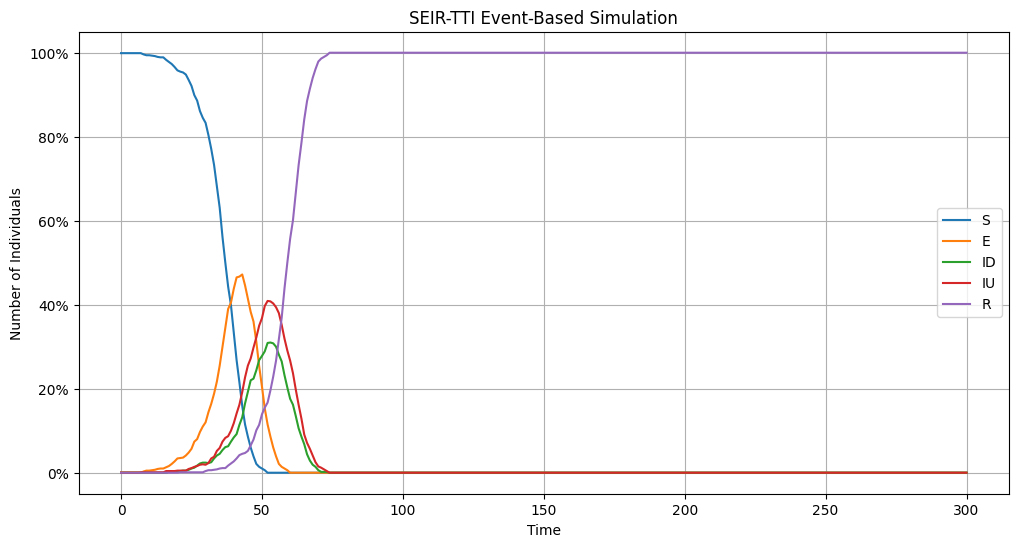

In [69]:
initial_infected = [0]
N = 1000
phi = 20
rho = 0.1
mu_ID_E = 0.4
TE = 7
TID = 14
TIU = 14

# Example usage
G = nx.random_regular_graph(d=phi, n=N)

result = run_seir_tti_event_based(G, initial_infected, phi, rho, mu_ID_E, TE, TID, TIU)
plot_seir_tti(result)

## Stratified SEIR with TTI



In [ ]:
# Define state constants outside the function to make them global
SUSCEPTIBLE, EXPOSED, INFECTED_DETECTED, INFECTED_UNDETECTED, RECOVERED = range(5)
EXPOSE_EVENT, BECOME_INFECTIOUS_EVENT, RECOVER_EVENT = range(3)

Event = namedtuple('Event', ['time', 'node', 'event_type'])

def run_seir_tti_event_based_stratified(G, initial_infected, groups, phi, rho, mu_ID_E, TE, TID, TIU, t_max=100):
    """
    Event-based SEIR-TTI simulation with stratified groups.

    Parameters:
    - G: networkx.Graph
    - initial_infected: list of node ids to initialize as exposed
    - groups: dict {node: group_index}
    - phi: (n x n) matrix of contact rates
    - rho, mu_ID_E, TE, TID, TIU: arrays of length n (per group)
    - t_max: maximum simulation time
    """
    states = {node: SUSCEPTIBLE for node in G.nodes()}
    event_queue = []
    time_series = {'time': [], 'S': [], 'E': [], 'ID': [], 'IU': [], 'R': []}
    infected_timers = {}

    for node in initial_infected:
        states[node] = EXPOSED
        heapq.heappush(event_queue, Event(0, node, EXPOSE_EVENT))

    current_time = 0

    while current_time <= t_max:
        # Process events at current time
        while event_queue and event_queue[0].time <= current_time:
            event = heapq.heappop(event_queue)
            node = event.node
            group = groups[node]

            if event.event_type == EXPOSE_EVENT and states[node] == EXPOSED:
                heapq.heappush(event_queue, Event(current_time + TE[group], node, BECOME_INFECTIOUS_EVENT))

            elif event.event_type == BECOME_INFECTIOUS_EVENT and states[node] == EXPOSED:
                if np.random.rand() < mu_ID_E[group]:
                    states[node] = INFECTED_DETECTED
                    heapq.heappush(event_queue, Event(current_time + TID[group], node, RECOVER_EVENT))
                else:
                    states[node] = INFECTED_UNDETECTED
                    infected_timers[node] = TIU[group]
                    heapq.heappush(event_queue, Event(current_time + TIU[group], node, RECOVER_EVENT))

            elif event.event_type == RECOVER_EVENT:
                if states[node] in [INFECTED_DETECTED, INFECTED_UNDETECTED]:
                    states[node] = RECOVERED
                    infected_timers.pop(node, None)

        # Spread infection (by IU only)
        for node in list(infected_timers):
            if infected_timers[node] > 0 and states[node] == INFECTED_UNDETECTED:
                g_i = groups[node]
                for neighbor in G.neighbors(node):
                    if states[neighbor] == SUSCEPTIBLE:
                        g_j = groups[neighbor]
                        infection_prob = phi[g_i][g_j] * rho[g_j]
                        if np.random.rand() < infection_prob:
                            states[neighbor] = EXPOSED
                            heapq.heappush(event_queue, Event(current_time, neighbor, EXPOSE_EVENT))
                infected_timers[node] -= 1

        # Count states
        counts = {SUSCEPTIBLE: 0, EXPOSED: 0, INFECTED_DETECTED: 0, INFECTED_UNDETECTED: 0, RECOVERED: 0}
        for state in states.values():
            counts[state] += 1

        # Access state constants directly instead of using eval
        for key, state_constant in zip(['S', 'E', 'ID', 'IU', 'R'], [SUSCEPTIBLE, EXPOSED, INFECTED_DETECTED, INFECTED_UNDETECTED, RECOVERED]):
            time_series[key].append(counts[state_constant])
        time_series['time'].append(current_time)

        current_time += 1

    return time_series

In [ ]:
def plot_event_based_trajectories(time_series, Num, title="SEIR-TTI Event-Based Simulation"):
    """
    Plot the overall time evolution of S, E, ID, IU, R for the full population.

    Parameters:
    - time_series: output of run_seir_tti_event_based_stratified
    - title: optional plot title
    """
    states = ['S', 'E', 'ID', 'IU', 'R']
    plt.figure(figsize=(10, 6))

    for s in states:
        plt.plot(time_series['time'], np.array(time_series[s])  / Num, label=s)

    plt.xlabel("Time (days)")
    plt.ylabel("Number of individuals")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def generate_stratified_graph_from_phi(group_sizes, phi, seed=None):
    """
    Generate a stratified contact graph where edges between groups follow expected contacts in phi.

    Parameters:
    - group_sizes: list of number of nodes per group
    - phi: matrix (n x n) indicating average contacts from group i to group j
    - seed: random seed for reproducibility

    Returns:
    - G: generated networkx.Graph
    - groups: dict {node: group_index}
    """
    np.random.seed(seed)
    n = len(group_sizes)
    G = nx.Graph()
    groups = {}
    node_id = 0
    group_nodes = []

    # Add nodes and assign groups
    for i, size in enumerate(group_sizes):
        nodes = list(range(node_id, node_id + size))
        G.add_nodes_from(nodes)
        for node in nodes:
            groups[node] = i
        group_nodes.append(nodes)
        node_id += size

    # Add edges between groups
    for i in range(n):
        for j in range(i, n):  # symmetric for undirected
            ni, nj = len(group_nodes[i]), len(group_nodes[j])
            total_contacts = int(phi[i][j] * ni)  # expected total contacts from i to j
            edges_added = 0

            while edges_added < total_contacts:
                u = np.random.choice(group_nodes[i])
                v = np.random.choice(group_nodes[j])
                if u != v and not G.has_edge(u, v):
                    G.add_edge(u, v)
                    edges_added += 1

    return G, groups

In [ ]:
# Parameters
group_sizes = [300, 1000, 2000]  # 3 groups

# Contact matrix: average number of contacts an individual from group i has with group j
phi = np.array([
    [5, 2, 4],
    [2, 10, 6],
    [4, 6, 15]
])

G, groups = generate_stratified_graph_from_phi(group_sizes, phi)

# Other parameters
rho = np.array([0.1, 0.1, 0.1])
mu_ID_E = np.array([0.6, 0.6, 0.6])
TE = np.array([7, 7, 7])
TID = np.array([14, 14, 14])
TIU = np.array([14, 14, 14])

initial_infected = [0, 1, 0]

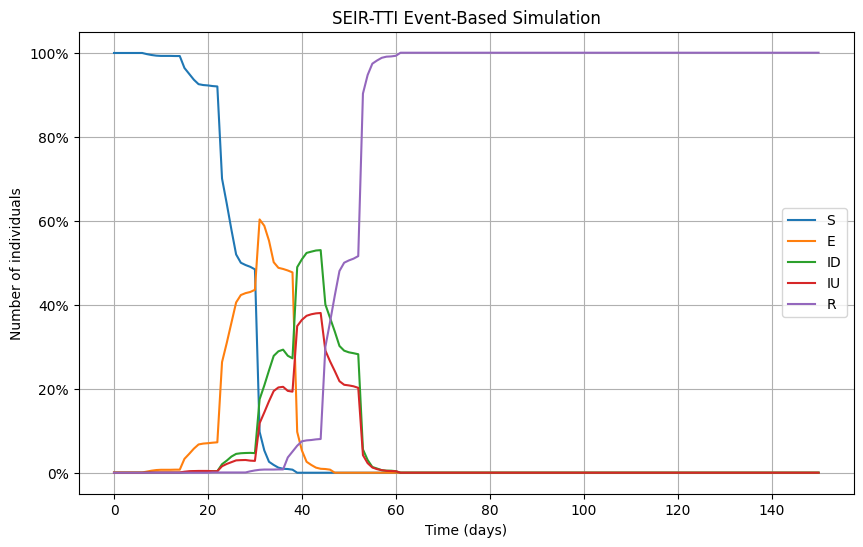

In [ ]:
# Run simulation
time_series = run_seir_tti_event_based_stratified(
    G, initial_infected, groups,
    phi, rho, mu_ID_E, TE, TID, TIU,
    t_max=150
)
plot_event_based_trajectories(time_series, Num=sum(group_sizes))